In [60]:
import sys

# Add the parent directory to the system path
sys.path.append("../04_survival_models/src")

In [61]:
import os

import numpy as np
import pandas as pd
import mlflow
from tqdm import tqdm
from uc2_functions import *
from azure.ai.ml import MLClient
from azure.identity import DefaultAzureCredential
from sklearn.metrics import roc_curve, roc_auc_score
from lifelines.statistics import multivariate_logrank_test, pairwise_logrank_test
from io import BytesIO
from PIL import Image

In [62]:
pd.set_option('future.no_silent_downcasting', True)

# Goal

The goal is to validate the models trained on DBURI using an external dataset from Firenze and to stratify the results based on risk predicted by survival models.

# Parameters

In [63]:
# Directories
DIR_SC = os.path.join(os.path.dirname(os.getcwd()), "sc")
DIR_FIGURES = "../figures"
PATH_EXTERNAL = "External_Validation_of_AI_model_Florence_MAP.xlsx"
PATH_EXTERNAL_INTEGRATION = "External validation Florence - Missing variables.xlsx"
PATH_EXTERNAL_INTEGRATION_NECROSIS = "External validation Florence - Missing variable necrosis.xlsx"
PARENT_RUN_ID = None
EXPERIMENT_NAME = "UC2_review_external_validation_Firenze_2025_09_1"
RANDOM_STATE = 42

# Functions

In [64]:
def calculate_ssign_score(df: pd.DataFrame) -> pd.DataFrame:
    """
    Computes the SSIGN score based on pre-processed features.

    This function calculates the score for each component of the SSIGN score
    (Pathological T, N, Metastasis, Tumor Size, Grade, Necrosis) and
    sums them to get the total score.

    Args:
        df: A pandas DataFrame containing the necessary columns:
            - 'IST_1_kidney1PathologicalStage2009' (numeric, mapped)
            - 'IST_1_kidney1PN2009_1_0' (boolean, from one-hot encoding)
            - 'IST_1_kidney1TumorDimension' (numeric, in cm)
            - 'IST_1_kidney1Grading' (numeric, mapped)
            - 'IST_1_kidney1Necrosis' (boolean)

    Returns:
        A new pandas DataFrame with added columns for each score component
        and the total 'ssign_score'.
    """
    # Make a copy to avoid modifying the original dataframe
    df_scores = df.copy()

    # 1. Pathological T category score
    # pT1 (1.0, 2.0) -> 0; pT2 (3.0, 4.0) -> +1; pT3 (5.0, 6.0, 7.0) -> +2; pT4 (8.0) -> +4
    pt_score_map = {1.0: 0, 2.0: 0, 3.0: 1, 4.0: 1, 5.0: 2, 6.0: 2, 7.0: 2, 8.0: 4}
    df_scores["ssign_component_pT"] = (
        df_scores["IST_1_kidney1PathologicalStage2009"].map(pt_score_map).fillna(0)
    )

    # 2. Regional lymph node status score
    # pNx/pN0 -> 0; pN1/pN2 -> +2
    # Based on your data, 'IST_1_kidney1PN2009_1_0' being True corresponds to pN1.
    df_scores["ssign_component_pN"] = np.where(
        df_scores["IST_1_kidney1PN2009_1_0"], 2, 0
    )

    # 3. Metastasis category score
    # M0 -> 0; M1 -> +4. Per your inclusion criteria, all are M0.
    df_scores["ssign_component_M"] = 0

    # 4. Tumor size score
    # <5 cm -> 0; >=5 cm -> +2
    df_scores["ssign_component_size"] = np.where(
        df_scores["IST_1_kidney1TumorDimension"] >= 5, 2, 0
    )

    # 5. Tumor (nuclear) grade score
    # Grade 1/2 -> 0; Grade 3 -> +1; Grade 4 -> +3
    grade_score_map = {1.0: 0, 2.0: 0, 3.0: 1, 4.0: 3}
    df_scores["ssign_component_grade"] = (
        df_scores["IST_1_kidney1Grading"].map(grade_score_map).fillna(0)
    )

    # 6. Tumor necrosis present score
    # No -> 0; Yes -> +2
    df_scores["ssign_component_necrosis"] = np.where(
        df_scores["IST_1_kidney1Necrosis"], 2, 0
    )

    # 7. Calculate the total SSIGN score
    score_components = [
        "ssign_component_pT",
        "ssign_component_pN",
        "ssign_component_M",
        "ssign_component_size",
        "ssign_component_grade",
        "ssign_component_necrosis",
    ]
    df_scores["ssign_score"] = df_scores[score_components].sum(axis=1)

    return df_scores

def handle_ocm_csm_none(df):
    # Ensure the 'ocm' and 'csm' columns are of nullable boolean type
    df['ocm'] = df['ocm'].astype(pd.BooleanDtype())
    df['csm'] = df['csm'].astype(pd.BooleanDtype())

    # Loop through the DataFrame rows
    for index, row in df.iterrows():
        if row['death'] == False:
            # Fill nans in ocm and csm with False (uniform with DBURI)
            if pd.isna(row['ocm']) and pd.isna(row['csm']):
                df.loc[index, 'ocm'] = False
                df.loc[index, 'csm'] = False
            else:
                raise ValueError(f"Error at index {index}: Inconsistent data where death is False")
        if row['death'] == True:
            if pd.isna(row['ocm']) and pd.isna(row['csm']):
                raise ValueError(f"Error at index {index}: Inconsistent data where death is True")
            else:
                continue
    return df

def validate_sksurv_model(
    model,
    y_train,
    X_test,
    y_test,
    tau,
    compute_auc:bool=True
):
    """
    Validate sksurv models using concordance_index_censored, concordance_index_ipcw,
    integrated_brier_score, mean_cumulative_dynamic_auc, and plot time-dependent AUC.

    Parameters:
    - model: Trained sksurv model.
    - y_train: Training survival data.
    - X_test: Test features.
    - y_test: Test survival data.
    - tau: Time point for IPCW concordance index and for AUC
    - compute_auc: if to compute Mean time-dependent AUC and AUC plot.

    Returns:
    - result_censored: Concordance index (censored).
    - result_ipcw: Concordance index (IPCW).
    - score_brier: Integrated Brier score.
    - mean_auc: Mean time-dependent AUC.
    - fig: Matplotlib figure object of the AUC plot.
    """
    # Predict risk scores
    try:
        predicted_risk = model.predict(X_test)
    except:
        predicted_risk = model.predict(X_test.values)
    
    # Evaluate Concordance Index (Censored)
    result_censored = concordance_index_censored(
        event_indicator=y_test["event"],
        event_time=y_test["time"],
        estimate=predicted_risk
    )[0]
    
    # Evaluate Concordance Index (IPCW)
    result_ipcw = concordance_index_ipcw(
        survival_train=y_train,
        survival_test=y_test,
        estimate=predicted_risk,
        tau=tau,
    )[0]
    
    # Compute Integrated Brier Score (IBS)
    # Determine time points between the 10th and 90th percentile
    all_times = np.concatenate([y_train["time"], y_test["time"]])
    lower, upper = np.percentile(all_times, [10, 90]) 
    brier_times = np.arange(lower, upper)
    
    # Predict survival probabilities at the specified time points
    try:
        surv_prob = np.row_stack([
            fn(brier_times) for fn in model.predict_survival_function(X_test)
        ])
    except:
        surv_prob = np.row_stack([
            fn(brier_times) for fn in model.predict_survival_function(X_test.values)
        ])
    
    # Calculate Integrated Brier Score
    score_brier = integrated_brier_score(
        survival_train=y_train,
        survival_test=y_test,
        estimate=surv_prob,
        times=brier_times
    )
    
    if compute_auc is True:
        # Compute Time-dependent AUC
        mean_auc = np.nan
        adjustment = 0
        while np.isnan(mean_auc):
            print(adjustment)
            # Define validation time points with adjustment
            va_times = np.linspace(1 + adjustment, tau - 1, int(tau/10))
            va_times = np.round(va_times, 0)
            try:
                auc, mean_auc = cumulative_dynamic_auc(
                    survival_train=y_train,
                    survival_test=y_test,
                    estimate=predicted_risk,
                    times=va_times
                )
            except Exception as e:
                print(f"Exception occurred: {e}")
                adjustment += 1
                continue  # Skip to the next iteration
            if np.isnan(mean_auc):
                adjustment += 1
            # Prevent infinite loop by setting a maximum adjustment
            if adjustment > 10:
                raise ValueError("Unable to compute mean_auc after multiple adjustments.")

        # Plot Time-dependent AUC
        fig, ax = plt.subplots(figsize=(6, 6))
        ax.plot(va_times, auc, marker="o", label="AUC at time t")
        ax.axhline(mean_auc, linestyle="--", color="red", label=f"Mean AUC = {mean_auc:.3f}")
        ax.set_xlabel("Time $t$ (months)")
        ax.set_ylabel("Time-dependent AUC")
        ax.grid(True)
        ax.legend()

        plt.close(fig)  # Prevent display in some environments
    
        return result_censored, result_ipcw, score_brier, mean_auc, fig
    else:
        return result_censored, result_ipcw, score_brier
    
def bootstrap_validation(
    model,
    y_train,
    X_test,
    y_test,
    tau,
    n_iterations=100,
    random_state=None
):
    """
    Perform bootstrapping on the test dataset to estimate metrics with confidence intervals.

    Parameters:
    - model: Trained sksurv model.
    - y_train: Training survival data.
    - X_test: Test features.
    - y_test: Test survival data.
    - tau: Time point for IPCW concordance index and for AUC.
    - n_iterations: Number of bootstrap samples.
    - random_state: Seed for reproducibility.

    Returns:
    - metrics_summary: Dictionary containing mean and confidence intervals for each metric.
    - figs: List of matplotlib figure objects from each iteration (optional).
    """
    if random_state is not None:
        np.random.seed(random_state)

    n_samples = X_test.shape[0]
    indices = np.arange(n_samples)

    # Lists to store metrics
    c_index_censored_list = []
    c_index_ipcw_list = []
    ibs_list = []

    for i in tqdm(range(n_iterations)):
        # Sample indices with replacement
        bootstrap_indices = np.random.choice(indices, size=n_samples, replace=True)
        X_test_bootstrap = X_test.iloc[bootstrap_indices] if isinstance(X_test, pd.DataFrame) else X_test[bootstrap_indices]
        y_test_bootstrap = y_test[bootstrap_indices]

        # Validate the model on the bootstrap sample
        result_censored, result_ipcw, score_brier = validate_sksurv_model(
            model=model,
            y_train=y_train,
            X_test=X_test_bootstrap,
            y_test=y_test_bootstrap,
            tau=tau,
            compute_auc=False
        )

        # Append metrics
        c_index_censored_list.append(result_censored)
        c_index_ipcw_list.append(result_ipcw)
        ibs_list.append(score_brier)

    # Compute summary statistics
    def compute_confidence_interval(data, confidence=0.95):
        mean = np.mean(data)
        std_err = np.std(data, ddof=1)
        n = len(data)
        h = std_err * 1.96  # For 95% confidence
        return mean, mean - h, mean + h

    # Time-dependent AUC without bootstrap (hard to stack figures)
    temp_0, temp_1, temp_2, mean_auc, fig = validate_sksurv_model(
            model=model,
            y_train=y_train,
            X_test=X_test,
            y_test=y_test,
            tau=tau,
            compute_auc=True
        )
    
    metrics_bootstrap = {
        'concordance_index_censored': compute_confidence_interval(c_index_censored_list),
        'concordance_index_ipcw': compute_confidence_interval(c_index_ipcw_list),
        'integrated_brier_score': compute_confidence_interval(ibs_list),
    }
    return metrics_bootstrap, mean_auc, fig

def create_subplot_from_dict(fig_dict, cols, ylim=None):
    """
    Create subplots from a dictionary of figures.
    
    Parameters:
    - fig_dict: Dictionary where keys are titles and values are Matplotlib figure objects.
    - cols: Number of columns for the subplots grid.
    - ylim: Tuple (ymin, ymax) for setting y-axis limits on each subplot (optional).
    """
    num_figures = len(fig_dict)
    rows = (num_figures + cols - 1) // cols  # Calculate number of rows

    # Create a new figure for the combined plot
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 5))
    axes = axes.flatten()  # Flatten to make it easier to loop over

    for idx, (title, original_fig) in enumerate(fig_dict.items()):
        original_axes = original_fig.get_axes()

        # Replot each axis's content into the new subplot
        for ax in original_axes:
            # Copy all lines, including their styles (e.g., dashed, dotted)
            for line in ax.get_lines():
                axes[idx].plot(
                    line.get_xdata(), 
                    line.get_ydata(), 
                    label=line.get_label(),
                    linestyle=line.get_linestyle(),  # Preserve linestyle (solid, dashed, etc.)
                    color=line.get_color()  # Preserve color
                )

            # Copy scatter plots if any
            for collection in ax.collections:
                axes[idx].scatter(
                    collection.get_offsets()[:, 0], 
                    collection.get_offsets()[:, 1], 
                    label=collection.get_label(),
                    color=collection.get_facecolor()  # Preserve scatter plot color
                )

            # Copy the title, labels, etc.
            axes[idx].set_title(title)
            axes[idx].set_xlabel(ax.get_xlabel())
            axes[idx].set_ylabel(ax.get_ylabel())

            # Set the custom y-axis limits if provided
            if ylim:
                axes[idx].set_ylim(ylim)

            # Copy grid settings if enabled in the original figure
            axes[idx].grid(ax.xaxis._major_tick_kw['gridOn'])

            # Copy legends
            if ax.get_legend():
                axes[idx].legend()

            # Handle horizontal lines (axhline) separately
            for line in ax.lines:
                if line.get_linestyle() == '--':  # Assuming dashed line for horizontal lines
                    y_value = line.get_ydata()[0]
                    axes[idx].axhline(
                        y=y_value,
                        color=line.get_color(), 
                        linestyle=line.get_linestyle(),
                        label=line.get_label()
                    )

    # Hide empty subplots if there are any
    for idx in range(num_figures, len(axes)):
        fig.delaxes(axes[idx])
    return fig

def print_bootstrap_metrics(metrics_bootstrap):
    """
    Prints evaluation metrics with their mean and 95% confidence intervals.

    Args:
        metrics_summary: Dictionary containing metrics and their confidence intervals.
    """
    for metric_name, (mean, lower_ci, upper_ci) in metrics_bootstrap.items():
        print(f"{metric_name}: Mean = {mean:.4f}, 95% CI = [{lower_ci:.4f}, {upper_ci:.4f}]")
        
def save_figure_as_jpeg(fig, filename, directory, dpi=300, quality=95):
    buf = BytesIO()
    fig.savefig(buf, format='png', dpi=dpi, bbox_inches='tight')
    buf.seek(0)
    img = Image.open(buf)
    os.makedirs(directory, exist_ok=True)
    img.convert("RGB").save(
        os.path.join(directory, filename),
        format='JPEG',
        quality=quality
    )
    buf.close()

# Data ingestion

## [internal]

In [65]:
# azureml-core of version 1.0.72 or higher is required
# azureml-dataprep[pandas] of version 1.1.34 or higher is required

subscription_id = "753a0b42-95dc-4871-b53e-160ceb0e6bc1"
resource_group = "rg-s-race-aml-dev-we"
workspace_name = "amlsraceamldevwe01"

workspace = Workspace(subscription_id, resource_group, workspace_name)

dataset = Dataset.get_by_name(workspace, name="UC2_raw_survival_csm_ohe_5yrs", version="23")
df_ohe = dataset.to_pandas_dataframe()
print(df_ohe.shape)
df_ohe.head()

{'infer_column_types': 'False', 'activity': 'to_pandas_dataframe'}
{'infer_column_types': 'False', 'activity': 'to_pandas_dataframe', 'activityApp': 'TabularDataset'}
(2536, 211)


,P_1_id,ANM_1_previousAbdominalOperations,ANM_1_moduliOK,ANM_1_performanceStatus,ANM_1_asa,ANM_1_patientBMI,ANM_1_hypertension,ANM_1_TerapiaDiabeteIpoglicemizzanti,ANM_1_charlsonIndexComorbiditiesMalattiaPolmonare,ANM_1_charlsonIndexComorbiditiesUlceraPeptica,...,DEG_1_examEmCreatininemiaRange_14-18,DEG_1_examEmCalcioRange_14-18,"DEG_1_examEmCalcioRange_2,10-2,60",DEG_1_examEmCalcioRange_2_1-2_6,DEG_1_examEmCalcioRange_2_10-2_60,DEG_1_examEmCalcioRange_2_25-2_75,death,csm,ocm,ttdeath
0,1.0,False,False,0.0,1.0,24.82,False,<NA>,True,False,...,False,False,False,False,True,False,False,False,True,60.0
1,4.0,False,False,1.0,2.0,NaN,True,False,False,False,...,False,False,False,False,True,False,False,<NA>,<NA>,60.0
2,5.0,True,False,1.0,2.0,NaN,True,False,False,False,...,False,False,False,False,True,False,False,False,False,60.0
3,6.0,False,False,1.0,2.0,29.76,False,<NA>,False,False,...,False,False,False,False,True,False,False,False,False,60.0
4,7.0,True,False,1.0,2.0,26.57,False,False,False,False,...,False,False,False,False,False,False,False,False,False,60.0


### Use schema from [internal]

Recreate the schema from tags:

In [66]:
tags = dataset.tags

dtypes = json.loads(tags["dtypes_json"])
is_ordinal = json.loads(tags["is_ordinal_json"])

for col in dtypes.keys():
    if dtypes[col] == "category":
        categories = (
            sorted(df_ohe[col].dropna().unique())
            if is_ordinal[col]
            else df_ohe[col].dropna().unique()
        )
        df_ohe[col] = pd.Categorical(
            df_ohe[col], categories=categories, ordered=is_ordinal[col]
        )
    else:
        df_ohe[col] = df_ohe[col].astype(dtypes[col])

## [external]

### [external] Original

First file shared by the external center, was missing 2 key variables

In [67]:
df_external_original = pd.read_excel(os.path.join(DIR_SC, PATH_EXTERNAL))
print(df_external_original.shape)
df_external_original.head(2)

(720, 44)


,ANM_1_age,ANM_1_asa,ANM_1_charlsonIndex,ANM_1_cciAge,ANM_1_performanceStatus,ANM_1_patientBMI,ANM_1_examEmCreatininemia,ANM_1_examEmeGFR,ANM_1_examEmEmoglobina,ANM_1_examEmEmoglobinaRange_14_0-18_0,...,IST_1_kidney1PN2009_1_0,IST_1_kidney1Grading,IST_1_kidney1MayoPN,IST_1_kidney1MayoGrading,IST_1_kidney1MayoScore,IST_1_kidney1MayoRisk,ocm,csm,death,ttdeath
0,32,3,4,4,0,22.9,14.5,4.2,12.1,0.0,...,pNx,1,pNx,1,0,Low,NaN,NaN,0.0,29
1,82,2,5,9,0,28.7,1.21,72,14.7,1.0,...,0,4,pN0,4,3,Intermediate,NaN,NaN,0.0,51


Add progressive index `ID` (manually checked by Principal Investigator that it matches the `ID` from the integration)

In [68]:
df_external_original = df_external_original.reset_index(drop=False).rename({"index": "ID"}, axis=1)

Remove space for variable name (data entry)

In [69]:
df_external_original = df_external_original.rename({'IST_1_kidney1PN2009_1_0 ': 'IST_1_kidney1PN2009_1_0'}, axis=1)

### [external] Integration

Integration with `INT_1_examinationTime` and `DEG_1_examEmEmoglobina`

In [70]:
df_external_integration = pd.read_excel(os.path.join(DIR_SC, PATH_EXTERNAL_INTEGRATION))
print(df_external_integration.shape)
df_external_integration.head(2)

(720, 3)


,ID,Mean operative time (min),Haemoglobinat discharge (g/dL)
0,1,141.0,12.8
1,2,155.0,12.8


Map column names to DBURI

In [71]:
dict_integration = {"Mean operative time (min)": "INT_1_examinationTime",
                    "Haemoglobinat discharge (g/dL)": "DEG_1_examEmEmoglobina"}
df_external_integration = df_external_integration.rename(dict_integration, axis=1)
df_external_integration.head(2)

,ID,INT_1_examinationTime,DEG_1_examEmEmoglobina
0,1,141.0,12.8
1,2,155.0,12.8


In [72]:
assert len(df_external_original) == len(df_external_integration)

Integration with `IST_1_kidney1Necrosis`

In [73]:
df_external_integration_necrosis = pd.read_excel(os.path.join(DIR_SC, PATH_EXTERNAL_INTEGRATION_NECROSIS))
print(df_external_integration_necrosis.shape)
df_external_integration_necrosis.head(2)

(720, 2)


,ID,Necrosis
0,1,0
1,2,0


Map column names to DBURI

In [74]:
dict_integration_necrosis = {
    "Necrosis": "IST_1_kidney1Necrosis",
}
df_external_integration_necrosis = df_external_integration_necrosis.rename(dict_integration_necrosis, axis=1)
df_external_integration_necrosis.head(2)

,ID,IST_1_kidney1Necrosis
0,1,0
1,2,0


In [75]:
assert len(df_external_original) == len(df_external_integration_necrosis)

### [external] Merge external and delete individual dataframes

In [76]:
# Two integrations
df_temp = pd.merge(
    df_external_integration, df_external_integration_necrosis, how="left", on="ID"
)
# Original external + two integrations
df_external = pd.merge(
    df_external_original, df_temp, how="left", on="ID"
)
del df_external_original, df_external_integration, df_external_integration_necrosis, df_temp
print(df_external.shape)
df_external.head(2)

(720, 48)


,ID,ANM_1_age,ANM_1_asa,ANM_1_charlsonIndex,ANM_1_cciAge,ANM_1_performanceStatus,ANM_1_patientBMI,ANM_1_examEmCreatininemia,ANM_1_examEmeGFR,ANM_1_examEmEmoglobina,...,IST_1_kidney1MayoGrading,IST_1_kidney1MayoScore,IST_1_kidney1MayoRisk,ocm,csm,death,ttdeath,INT_1_examinationTime,DEG_1_examEmEmoglobina,IST_1_kidney1Necrosis
0,0,32,3,4,4,0,22.9,14.5,4.2,12.1,...,1,0,Low,NaN,NaN,0.0,29,NaN,NaN,NaN
1,1,82,2,5,9,0,28.7,1.21,72,14.7,...,4,3,Intermediate,NaN,NaN,0.0,51,141.0,12.8,0.0


### [external] Drop columns with more than 50% of missing

In [77]:
not_features = ["P_1_id", "death", "csm", "ocm", "ttdeath"]
threshold = 0.5 * len(df_external)


# Print the original shape
print("Original shape:", df_external.shape)
# Get the list of original column names
original_columns = df_external.columns
# Create a list of columns to drop based on the threshold, excluding the 'not_features' list
columns_to_drop = [col for col in original_columns if col not in not_features and df_external[col].isna().sum() > threshold]
# Drop the identified columns
df_external = df_external.drop(columns=columns_to_drop)
# Print the new shape after dropping columns
print("New shape:", df_external.shape)
# Display the dropped columns
print("Dropped columns:", columns_to_drop)

Original shape: (720, 48)
New shape: (720, 47)
Dropped columns: ['DEG_1_examEmCalcio']


# [external] Target distribution

In [78]:
print(df_external['death'].value_counts(dropna=False))
print(df_external['ocm'].value_counts(dropna=False))
print(df_external['csm'].value_counts(dropna=False))

death
0.0    650
1.0     68
NaN      2
Name: count, dtype: int64
ocm
NaN    669
1.0     32
0.0     19
Name: count, dtype: int64
csm
NaN    669
0.0     34
1.0     17
Name: count, dtype: int64


# [external] Columns from external dataset not present in [internal]

In [79]:
delta_columns = list(set(df_external.columns) - set(dtypes.keys()))
print(delta_columns)
print(df_external.shape)
df_external.drop(delta_columns, axis=1, inplace=True)
print(df_external.shape)

['Symptoms at onset', 'ID']
(720, 47)
(720, 45)


# [external] Map data (preprocessing)

In [80]:
df_external = df_external.replace(' ', np.nan).replace('  ', np.nan)
df_external['ANM_1_patientBMI'] = df_external['ANM_1_patientBMI'].replace({" kg/m²": "",
                                                                          "  \t": "",
                                                                          ",": ".",
                                                                          }, regex=True)
df_external['IST_1_kidney1MayoPN'] = df_external['IST_1_kidney1MayoPN'].replace({
    "pN0": 0.0,
    "pN1": 1.0,
    "pNx": 2.0
})
df_external["ANM_1_symptomsBeginning_Sintomiall'esordio"] = df_external["ANM_1_symptomsBeginning_Sintomiall'esordio"].replace({2: 1})
df_external['IST_1_kidney1PN2009_1_0'] = df_external['IST_1_kidney1PN2009_1_0'].replace({
    "pN0": 0.0,
    "pN1": 1.0,
    "pNx": 0.0,
    2: 0.0
})
df_external['IST_1_kidney1PathologicalStage2009'] = df_external['IST_1_kidney1PathologicalStage2009'].replace({
    "pT1a": 1.0,
    "pT1b": 2.0,
    "pT2a": 3.0,
    "pT2b": 4.0,
    "pT3a": 5.0,
    "pT3b": 6.0,
    "pT3c": 7.0,
    "pT4": 8.0,
    "pTx": np.nan,
})
df_external['ANM_1_kidney1ClinicalStage2009'] = df_external['ANM_1_kidney1ClinicalStage2009'].replace({
    "T1a": 1.0,
    "T1b": 2.0,
    "T2a": 3.0,
    "T2b": 4.0,
    "T3a": 5.0,
    "T3b": 6.0,
    "T3c": 7.0,
    "T4": 8.0,
    "Tx": np.nan,
})
df_external['IST_1_kidney1MayoRisk'] = df_external['IST_1_kidney1MayoRisk'].replace({
    "Low": 1.0,
    "Intermediate": 2.0,
    "High": 3.0,
})
df_external['death'] = df_external['death'].replace({
    2: 1,
})

In [81]:
col_to_fix = df_external.columns

for col in col_to_fix:
    print(col)
    u = df_external[col].unique()
    if len(u) > 10:
        print("More than 10 unique values")
    else:
        try:
            print(sorted(u))
        except:
            print(u)
    print()
    print()

ANM_1_age
More than 10 unique values


ANM_1_asa
[1, 2, 3]


ANM_1_charlsonIndex
[1, 2, 3, 4, 5, 6, 7, 8, 9, 12]


ANM_1_cciAge
More than 10 unique values


ANM_1_performanceStatus
[0, 1, 2, 3]


ANM_1_patientBMI
More than 10 unique values


ANM_1_examEmCreatininemia
More than 10 unique values


ANM_1_examEmeGFR
More than 10 unique values


ANM_1_examEmEmoglobina
More than 10 unique values


ANM_1_examEmEmoglobinaRange_14_0-18_0
[0.0, 1.0, nan]


ANM_1_examEmPiastrine
More than 10 unique values


ANM_1_examToolEchocardiogram
[1]


ANM_1_examToolEchoColorDoppler
[0, 1]


ANM_1_examToolScintigraphy_Noneseguita
[1]


ANM_1_examToolTargetedRx
[0]


ANM_1_symptomsBeginning_Pazienteasintomatico
[0, 1]


ANM_1_symptomsBeginningLocalMacroematuria
[0, 1]


ANM_1_symptomsBeginning_Sintomiall'esordio
[0, 1]


ANM_1_thrombusNeoplastic
[0, 1]


ANM_1_kidney1ClinicalStage2009
[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0]


ANM_1_kidney1ClinicalStage2009_4lev
[1, 2, 3, 4]


ANM_1_kidney1NeoplasiaDimension

#  [external] Use schema from [internal]

In [82]:
for col in dtypes.keys():
    if col in df_external:
        if dtypes[col] == "category":
            categories = (
                sorted(df_external[col].dropna().unique())
                if is_ordinal[col]
                else df_external[col].dropna().unique()
            )
            df_external[col] = pd.Categorical(
                df_external[col], categories=categories, ordered=is_ordinal[col]
            )
        else:
            df_external[col] = df_external[col].astype(dtypes[col])
    else:
        continue

#  [external] Drop na on event

In [83]:
print(df_external.shape)
df_external = df_external.dropna(subset=["death", "ttdeath"])
print(df_external.shape)

(720, 45)
(718, 45)


#  [external] Drop unknown cause of death

In [84]:
print(df_external.shape)
df_external = df_external[~((df_external['death'] == True) & (pd.isna(df_external['csm'])) & (pd.isna(df_external['ocm'])))]
print(df_external.shape)

(718, 45)
(701, 45)


# [external] ttdeath = 0 months

We don't have any ttdeath = 0 months in the internal dataset, while there is one in the external dataset. We consider this ttdeath as 1 month.

In [85]:
print(df_external["ttdeath"].value_counts().sort_index())

ttdeath
0.0      1
1.0     16
2.0      5
3.0      9
4.0     10
        ..
78.0     2
79.0     2
80.0     1
83.0     1
84.0     1
Name: count, Length: 82, dtype: int64


In [86]:
df_external["ttdeath"] = df_external["ttdeath"].replace({0: 1})

#  [external] Fill nans in ocm and csm with False as in [internal]

In [87]:
print(df_external['death'].value_counts(dropna=False))
print(df_external['csm'].value_counts(dropna=False))

death
False    650
True      51
Name: count, dtype: Int64
csm
<NA>     650
False     34
True      17
Name: count, dtype: Int64


In [88]:
df_external = handle_ocm_csm_none(df_external)

In [89]:
print(df_external['death'].value_counts(dropna=False))
print(df_external['csm'].value_counts(dropna=False))

death
False    650
True      51
Name: count, dtype: Int64
csm
False    684
True      17
Name: count, dtype: Int64


#  [external] Only cancer-specific mortality (cut at 5 years)

In [90]:
print(df_external.shape)
df_external_csm_5yrs = df_external.copy()
cut_months = 60
df_external_csm_5yrs = df_external_csm_5yrs[
    (df_external_csm_5yrs["ocm"] == False) | (df_external_csm_5yrs["ttdeath"] >= cut_months)
]
# Clip the ttdeath column at 60
df_external_csm_5yrs["ttdeath"] = df_external_csm_5yrs["ttdeath"].apply(
    lambda x: x if x <= 60 else 60
)
# Update the death column based on ttdeath values (censor over 60 months)
df_external_csm_5yrs.loc[df_external_csm_5yrs["ttdeath"] == 60, "death"] = False
print(df_external_csm_5yrs.shape)

(701, 45)
(674, 45)


In [91]:
print(df_external_csm_5yrs['death'].value_counts(dropna=False))
print(df_external_csm_5yrs['ocm'].value_counts(dropna=False))
print(df_external_csm_5yrs['csm'].value_counts(dropna=False))
print()
print(df_external_csm_5yrs['death'].value_counts(dropna=False, normalize=True))
print(df_external_csm_5yrs['ocm'].value_counts(dropna=False, normalize=True))
print(df_external_csm_5yrs['csm'].value_counts(dropna=False, normalize=True))

death
False    658
True      16
Name: count, dtype: Int64
ocm
False    669
True       5
Name: count, dtype: Int64
csm
False    658
True      16
Name: count, dtype: Int64

death
False    0.976261
True     0.023739
Name: proportion, dtype: Float64
ocm
False    0.992582
True     0.007418
Name: proportion, dtype: Float64
csm
False    0.976261
True     0.023739
Name: proportion, dtype: Float64


# [external] Kaplan–Meier

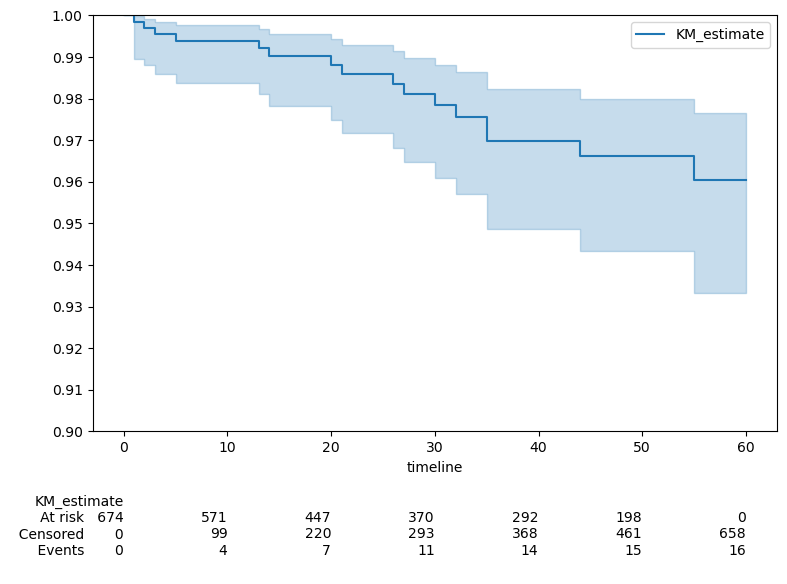

In [92]:
plt.figure(figsize=(8, 6))
ax = plt.subplot(111)

kmf_0 = KaplanMeierFitter()
ax = kmf_0.fit(durations=df_external_csm_5yrs['ttdeath'],
                     event_observed=df_external_csm_5yrs['death']).plot_survival_function(ax=ax)
ax.set_ylim(0.9, 1)
ax.set_yticks(np.arange(0.9, 1.01, 0.01))
add_at_risk_counts(kmf_0, ax=ax)
plt.tight_layout()

# Start mlflow run

In [93]:
mlflow.set_experiment(EXPERIMENT_NAME)
mlflow.start_run(run_name=EXPERIMENT_NAME)
if PARENT_RUN_ID:
    mlflow.set_tag("parent_run_id", PARENT_RUN_ID)

# List of figures

Create a dict of figures, so then we can create a single comparative plot at the end

In [94]:
dict_fig = dict()

# [external] validation of `CoxPHSurvivalAnalysis_ssign_univariate_T1`

## Load model trained on [internal]

In [95]:
run_id = '6da9e6db-954a-4c13-9314-adc48a16e057'
artifact_path = 'raw_CoxPHSurvivalAnalysis_ssign_univariate_T1_42.pkl'


mlflow.start_run(run_name=artifact_path.split(".pkl")[0], nested=True)
mlflow.log_param("run_id", run_id)
mlflow.log_param("artifact_path", artifact_path)
file_path = mlflow.artifacts.download_artifacts(run_id=run_id, # `Overview > Name` in the UI
                                                artifact_path=artifact_path) # `Outputs + tags > .pkl filename` in the UI

# Load model
cox_ssign_univariate = joblib.load(
    file_path
)
# List of features
features_ssign_univariate = cox_ssign_univariate.feature_names_in_
print(features_ssign_univariate)
mlflow.log_param("n_features_in", len(features_ssign_univariate))
mlflow.log_param("features_in", features_ssign_univariate)

['ssign_score']


array(['ssign_score'], dtype=object)

## Infer rule-based SSIGN prognostic score

In [96]:
# Check is all the required variables are present in external dataset
features_ssign = [
            'IST_1_kidney1PathologicalStage2009',
            'IST_1_kidney1PN2009_1_0',
            'IST_1_kidney1TumorDimension',
            'IST_1_kidney1Grading',
            'IST_1_kidney1Necrosis']
# The features are then used to compute the rule-based ssign score. The score is feed into the cox model, as paper at https://pubmed.ncbi.nlm.nih.gov/19062157/

for col in features_ssign:
    if col in df_external_csm_5yrs:
        continue
    else:
        print(col)

## Missing

In [97]:
# Check is all the required variables are present in external dataset
for col in features_ssign:
    print(col)
    print(df_external_csm_5yrs[col].isna().sum() / df_external_csm_5yrs.shape[0])
    print()

IST_1_kidney1PathologicalStage2009
0.002967359050445104

IST_1_kidney1PN2009_1_0
0.001483679525222552

IST_1_kidney1TumorDimension
0.001483679525222552

IST_1_kidney1Grading
0.001483679525222552

IST_1_kidney1Necrosis
0.001483679525222552



## [external] Score

### [external] Drop na on model features

In [98]:
print(df_external_csm_5yrs.shape)
print(df_external_csm_5yrs['death'].value_counts(dropna=False))
df_external_csm_5yrs_not_imputed = df_external_csm_5yrs.dropna(subset=features_ssign)
print()
print(df_external_csm_5yrs_not_imputed.shape)
print(df_external_csm_5yrs_not_imputed['death'].value_counts(dropna=False))

(674, 45)
death
False    658
True      16
Name: count, dtype: Int64

(668, 45)
death
False    652
True      16
Name: count, dtype: Int64


### Compute rule-based SSIGN score

In [99]:
df_external_csm_5yrs_not_imputed = calculate_ssign_score(df_external_csm_5yrs_not_imputed)

### [external] Score

In [100]:
# Needed for param survival_train `Survival times for training data to estimate the censoring distribution`
y_train = np.array(
    [(event, time) for event, time in zip(df_ohe["death"], df_ohe["ttdeath"])],
    dtype=[("event", bool), ("time", float)],
)
# External dataset
X = df_external_csm_5yrs_not_imputed[features_ssign_univariate]
y = np.array(
    [(event, time) for event, time in zip(df_external_csm_5yrs_not_imputed["death"], df_external_csm_5yrs_not_imputed["ttdeath"])],
    dtype=[("event", bool), ("time", float)],
)
mlflow.log_param(
    "death_perc_5yrs",
    pd.Series(y["event"]).value_counts(sort=True, normalize=True)[True],
)

0.023952095808383235

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 14.60it/s]


0
concordance_index_censored: Mean = 0.8107, 95% CI = [0.7093, 0.9120]
concordance_index_ipcw: Mean = 0.7972, 95% CI = [0.6960, 0.8984]
integrated_brier_score: Mean = 0.0184, 95% CI = [0.0100, 0.0268]
Cumulative/dynamic AUC for right-censored time-to-event data: 0.8089


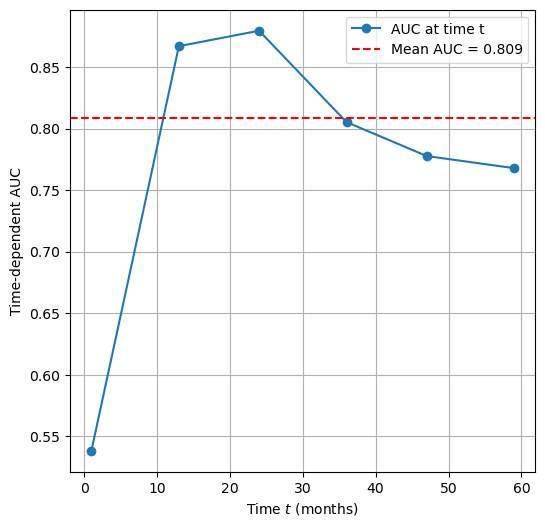

In [101]:
metrics_bootstrap, mean_auc, fig = bootstrap_validation(
    model=cox_ssign_univariate,
    y_train=y_train,
    X_test=X,
    y_test=y,
    tau=60,
    n_iterations=100,
    random_state=RANDOM_STATE
)
mlflow.log_metric("concordance_index_censored_mean_boostrap", metrics_bootstrap['concordance_index_censored'][0])
mlflow.log_metric("concordance_index_censored_ci_low", metrics_bootstrap['concordance_index_censored'][1])
mlflow.log_metric("concordance_index_censored_ci_high", metrics_bootstrap['concordance_index_censored'][2])

mlflow.log_metric("concordance_index_ipcw_mean_boostrap", metrics_bootstrap['concordance_index_ipcw'][0])
mlflow.log_metric("concordance_index_ipcw_ci_low", metrics_bootstrap['concordance_index_ipcw'][1])
mlflow.log_metric("concordance_index_ipcw_ci_high", metrics_bootstrap['concordance_index_ipcw'][2])

mlflow.log_metric("integrated_brier_score_mean_boostrap", metrics_bootstrap['concordance_index_ipcw'][0])
mlflow.log_metric("integrated_brier_score_ci_low", metrics_bootstrap['concordance_index_ipcw'][1])
mlflow.log_metric("integrated_brier_score_ci_high", metrics_bootstrap['concordance_index_ipcw'][2])

mlflow.log_metric("mean_cumulative_dynamic_auc", mean_auc)
mlflow.log_figure(fig, "time_dependent_auc.png")
mlflow.end_run()
print_bootstrap_metrics(metrics_bootstrap)
print("Cumulative/dynamic AUC for right-censored time-to-event data:", round(mean_auc, 4))
dict_fig[artifact_path] = fig
fig

In [102]:
del df_external_csm_5yrs_not_imputed, cox_ssign_univariate

# [external] validation of `CoxPHSurvivalAnalysis_grant_finetune_T1_final`

##  [external] Binarize variables

In [103]:
## Binarize age
df_external_csm_5yrs['ANM_1_age_binary'] = (df_external_csm_5yrs['ANM_1_age'] > 60).where(df_external_csm_5yrs['ANM_1_age'].notna(), np.nan).astype("boolean")
## Binarize pT
df_external_csm_5yrs['IST_1_kidney1PathologicalStage2009_binary'] = (df_external_csm_5yrs['IST_1_kidney1PathologicalStage2009'] >= 6).where(df_external_csm_5yrs['IST_1_kidney1PathologicalStage2009'].notna(), np.nan).astype("boolean")
## Binarize grading
df_external_csm_5yrs['IST_1_kidney1Grading_binary'] = (df_external_csm_5yrs['IST_1_kidney1Grading'] >= 3).where(df_external_csm_5yrs['IST_1_kidney1Grading'].notna(), np.nan).astype("boolean")

## Load model trained on [internal]

In [104]:
run_id = 'ea289aa3-8c62-4372-90aa-7212015afe49'
artifact_path = 'raw_CoxPHSurvivalAnalysis_grant_finetune_T1_final_42.pkl'


mlflow.start_run(run_name=artifact_path.split(".pkl")[0], nested=True)
mlflow.log_param("run_id", run_id)
mlflow.log_param("artifact_path", artifact_path)
file_path = mlflow.artifacts.download_artifacts(run_id=run_id, # `Overview > Name` in the UI
                                                artifact_path=artifact_path) # `Outputs + tags > .pkl filename` in the UI

# Load model
cox_grant_finetune = joblib.load(
    file_path
)
# List of features
features_grant_finetune = cox_grant_finetune.feature_names_in_
print(features_grant_finetune)
mlflow.log_param("n_features_in", len(features_grant_finetune))
mlflow.log_param("features_in", features_grant_finetune)

['ANM_1_age_binary' 'IST_1_kidney1PathologicalStage2009_binary'
 'IST_1_kidney1PN2009_1_0' 'IST_1_kidney1Grading_binary']


array(['ANM_1_age_binary', 'IST_1_kidney1PathologicalStage2009_binary',
       'IST_1_kidney1PN2009_1_0', 'IST_1_kidney1Grading_binary'],
      dtype=object)

In [105]:
# Check is all the required variables are present in external dataset
for col in features_grant_finetune:
    if col in df_external_csm_5yrs:
        continue
    else:
        print(col)

## Missing

In [106]:
# Check is all the required variables are present in external dataset
for col in features_grant_finetune:
    print(col)
    print(df_external_csm_5yrs[col].isna().sum() / df_external_csm_5yrs.shape[0])
    print()

ANM_1_age_binary
0.0

IST_1_kidney1PathologicalStage2009_binary
0.002967359050445104

IST_1_kidney1PN2009_1_0
0.001483679525222552

IST_1_kidney1Grading_binary
0.001483679525222552



## [external] Score

### [external] Drop na on model features

In [107]:
print(df_external_csm_5yrs.shape)
print(df_external_csm_5yrs['death'].value_counts(dropna=False))
df_external_csm_5yrs_not_imputed = df_external_csm_5yrs.dropna(subset=features_grant_finetune)
print()
print(df_external_csm_5yrs_not_imputed.shape)
print(df_external_csm_5yrs_not_imputed['death'].value_counts(dropna=False))

(674, 48)
death
False    658
True      16
Name: count, dtype: Int64

(670, 48)
death
False    654
True      16
Name: count, dtype: Int64


### [external] Score

In [108]:
# Needed for param survival_train `Survival times for training data to estimate the censoring distribution`
y_train = np.array(
    [(event, time) for event, time in zip(df_ohe["death"], df_ohe["ttdeath"])],
    dtype=[("event", bool), ("time", float)],
)
# External dataset
X = df_external_csm_5yrs_not_imputed[features_grant_finetune]
y = np.array(
    [(event, time) for event, time in zip(df_external_csm_5yrs_not_imputed["death"], df_external_csm_5yrs_not_imputed["ttdeath"])],
    dtype=[("event", bool), ("time", float)],
)
mlflow.log_param(
    "death_perc_5yrs",
    pd.Series(y["event"]).value_counts(sort=True, normalize=True)[True],
)

0.023880597014925373

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 13.64it/s]


0
concordance_index_censored: Mean = 0.7580, 95% CI = [0.6121, 0.9039]
concordance_index_ipcw: Mean = 0.7721, 95% CI = [0.6431, 0.9011]
integrated_brier_score: Mean = 0.0174, 95% CI = [0.0092, 0.0255]
Cumulative/dynamic AUC for right-censored time-to-event data: 0.7304


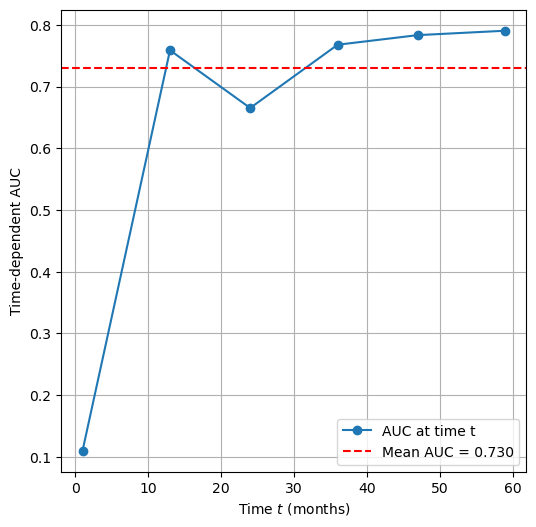

In [109]:
metrics_bootstrap, mean_auc, fig = bootstrap_validation(
    model=cox_grant_finetune,
    y_train=y_train,
    X_test=X,
    y_test=y,
    tau=60,
    n_iterations=100,
    random_state=RANDOM_STATE
)
mlflow.log_metric("concordance_index_censored_mean_boostrap", metrics_bootstrap['concordance_index_censored'][0])
mlflow.log_metric("concordance_index_censored_ci_low", metrics_bootstrap['concordance_index_censored'][1])
mlflow.log_metric("concordance_index_censored_ci_high", metrics_bootstrap['concordance_index_censored'][2])

mlflow.log_metric("concordance_index_ipcw_mean_boostrap", metrics_bootstrap['concordance_index_ipcw'][0])
mlflow.log_metric("concordance_index_ipcw_ci_low", metrics_bootstrap['concordance_index_ipcw'][1])
mlflow.log_metric("concordance_index_ipcw_ci_high", metrics_bootstrap['concordance_index_ipcw'][2])

mlflow.log_metric("integrated_brier_score_mean_boostrap", metrics_bootstrap['concordance_index_ipcw'][0])
mlflow.log_metric("integrated_brier_score_ci_low", metrics_bootstrap['concordance_index_ipcw'][1])
mlflow.log_metric("integrated_brier_score_ci_high", metrics_bootstrap['concordance_index_ipcw'][2])

mlflow.log_metric("mean_cumulative_dynamic_auc", mean_auc)
mlflow.log_figure(fig, "time_dependent_auc.png")
mlflow.end_run()
print_bootstrap_metrics(metrics_bootstrap)
print("Cumulative/dynamic AUC for right-censored time-to-event data:", round(mean_auc, 4))
dict_fig[artifact_path] = fig
fig

In [110]:
del df_external_csm_5yrs_not_imputed, cox_grant_finetune

# [external] validation of `ExtraSurvivalTrees_T0_final`

## Load model trained on [internal]

In [111]:
run_id = '4df6fac1-2f1e-4717-bcbc-e81a6883bec3'
artifact_path = 'raw_ExtraSurvivalTrees_T0_DBURI_42.pkl'


mlflow.start_run(run_name=artifact_path.split(".pkl")[0], nested=True)
mlflow.log_param("run_id", run_id)
mlflow.log_param("artifact_path", artifact_path)
file_path = mlflow.artifacts.download_artifacts(run_id=run_id, # `Overview > Name` in the UI
                                                artifact_path=artifact_path) # `Outputs + tags > .pkl filename` in the UI

# Load model
est_t0_dburi = joblib.load(
    file_path
)
# List of features
features_est_t0_dburi = est_t0_dburi.feature_names_in_
print(features_est_t0_dburi)
mlflow.log_param("n_features_in", len(features_est_t0_dburi))
mlflow.log_param("features_in", features_est_t0_dburi)

['ANM_1_examEmPiastrine' 'ANM_1_kidney1NeoplasiaDimension1'
 'ANM_1_examEmEmoglobina' 'ANM_1_age' 'ANM_1_performanceStatus'
 'ANM_1_examEmeGFR' 'ANM_1_lymphadenopathy_Positivo' 'ANM_1_patientBMI']


array(['ANM_1_examEmPiastrine', 'ANM_1_kidney1NeoplasiaDimension1',
       'ANM_1_examEmEmoglobina', 'ANM_1_age', 'ANM_1_performanceStatus',
       'ANM_1_examEmeGFR', 'ANM_1_lymphadenopathy_Positivo',
       'ANM_1_patientBMI'], dtype=object)

## Missing

In [112]:
# Check is all the required variables are present in external dataset
for col in features_est_t0_dburi:
    print(col)
    print(df_external_csm_5yrs[col].isna().sum() / df_external_csm_5yrs.shape[0])
    print()

ANM_1_examEmPiastrine
0.13056379821958458

ANM_1_kidney1NeoplasiaDimension1
0.002967359050445104

ANM_1_examEmEmoglobina
0.008902077151335312

ANM_1_age
0.0

ANM_1_performanceStatus
0.0

ANM_1_examEmeGFR
0.06231454005934718

ANM_1_lymphadenopathy_Positivo
0.0

ANM_1_patientBMI
0.0



## [external] Score

### [external] Drop na on model features

In [113]:
print(df_external_csm_5yrs.shape)
print(df_external_csm_5yrs['death'].value_counts(dropna=False))
df_external_csm_5yrs_not_imputed = df_external_csm_5yrs.dropna(subset=features_est_t0_dburi)
print()
print(df_external_csm_5yrs_not_imputed.shape)
print(df_external_csm_5yrs_not_imputed['death'].value_counts(dropna=False))

(674, 48)
death
False    658
True      16
Name: count, dtype: Int64

(580, 48)
death
False    566
True      14
Name: count, dtype: Int64


### [external] Score

In [114]:
# Needed for param survival_train `Survival times for training data to estimate the censoring distribution`
y_train = np.array(
    [(event, time) for event, time in zip(df_ohe["death"], df_ohe["ttdeath"])],
    dtype=[("event", bool), ("time", float)],
)
# External dataset
X = df_external_csm_5yrs_not_imputed[features_est_t0_dburi]
y = np.array(
    [(event, time) for event, time in zip(df_external_csm_5yrs_not_imputed["death"], df_external_csm_5yrs_not_imputed["ttdeath"])],
    dtype=[("event", bool), ("time", float)],
)
mlflow.log_param(
    "death_perc_5yrs",
    pd.Series(y["event"]).value_counts(sort=True, normalize=True)[True],
)

0.02413793103448276

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:10<00:00,  9.93it/s]


0
concordance_index_censored: Mean = 0.8840, 95% CI = [0.8099, 0.9580]
concordance_index_ipcw: Mean = 0.8653, 95% CI = [0.7833, 0.9472]
integrated_brier_score: Mean = 0.0164, 95% CI = [0.0084, 0.0244]
Cumulative/dynamic AUC for right-censored time-to-event data: 0.8946


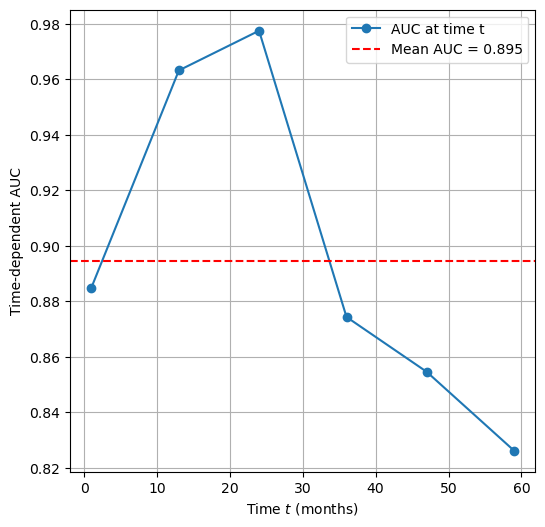

In [115]:
metrics_bootstrap, mean_auc, fig = bootstrap_validation(
    model=est_t0_dburi,
    y_train=y_train,
    X_test=X,
    y_test=y,
    tau=60,
    n_iterations=100,
    random_state=RANDOM_STATE
)
mlflow.log_metric("concordance_index_censored_mean_boostrap", metrics_bootstrap['concordance_index_censored'][0])
mlflow.log_metric("concordance_index_censored_ci_low", metrics_bootstrap['concordance_index_censored'][1])
mlflow.log_metric("concordance_index_censored_ci_high", metrics_bootstrap['concordance_index_censored'][2])

mlflow.log_metric("concordance_index_ipcw_mean_boostrap", metrics_bootstrap['concordance_index_ipcw'][0])
mlflow.log_metric("concordance_index_ipcw_ci_low", metrics_bootstrap['concordance_index_ipcw'][1])
mlflow.log_metric("concordance_index_ipcw_ci_high", metrics_bootstrap['concordance_index_ipcw'][2])

mlflow.log_metric("integrated_brier_score_mean_boostrap", metrics_bootstrap['concordance_index_ipcw'][0])
mlflow.log_metric("integrated_brier_score_ci_low", metrics_bootstrap['concordance_index_ipcw'][1])
mlflow.log_metric("integrated_brier_score_ci_high", metrics_bootstrap['concordance_index_ipcw'][2])

mlflow.log_metric("mean_cumulative_dynamic_auc", mean_auc)
mlflow.log_figure(fig, "time_dependent_auc.png")
mlflow.end_run()
print_bootstrap_metrics(metrics_bootstrap)
print("Cumulative/dynamic AUC for right-censored time-to-event data:", round(mean_auc, 4))
dict_fig[artifact_path] = fig
fig

In [116]:
del df_external_csm_5yrs_not_imputed, est_t0_dburi

# Compare cumulative_dynamic_auc

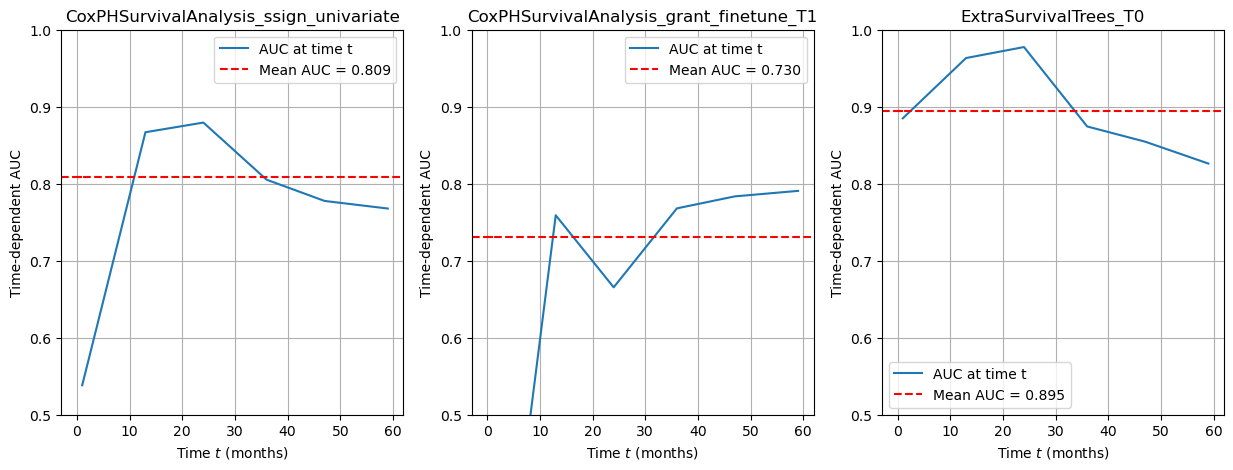

In [117]:
# Define the lambda function to convert keys to uppercase
transform_key = lambda k: "_".join(k.split("raw_")[1].split("_")[:-2])

# Simplify titles (keys)
dict_fig_tranform = {transform_key(k): v for k, v in dict_fig.items()}

# PLot single chart and save jpeg
combined_fig = create_subplot_from_dict(dict_fig_tranform, cols=3, ylim=(0.5, 1))
save_figure_as_jpeg(combined_fig, "auc_external_validation.jpg", DIR_FIGURES, dpi=300, quality=95)
plt.show()

# End mlflow run

In [118]:
mlflow.end_run()